# Install and load modules

Zipline only works with an older version of pandas. It is necessary to downgrade to the version of pandas that is 0.22.0. Zipline is not part of the base modules in the server, therefore, we need to download it everytime the server starts. The following cell magic allows us to run terminal commans to select our pandas version and download zipline.

In [1]:
%%bash
pip install pandas==0.22.0
pip install zipline

  Using cached https://files.pythonhosted.org/packages/da/c6/0936bc5814b429fddb5d6252566fe73a3e40372e6ceaf87de3dec1326f28/pandas-0.22.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


ERROR: yfinance 0.1.42 has requirement pandas>=0.24, but you'll have pandas 0.22.0 which is incompatible.


In [2]:
# Modules need to import data and run EDA
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import zipline

# Zipline Data compatibility

After much trail and error, we have discovered that Zipline works best with our custom data if we convert our data into a pandas panel. We import and read in the CSV files that were created in the download dataset notebook. We store each newly created pandas dataframe into an ordered dictionary so that we can concatenate all of dataframes. Since zipline works with continious data, we will impute missing observations with the mean of previous stock information. We will be changing the data time of our data to UTC. This further ensures that our data is continious. 

In [3]:
# Store the different datasets
data = {}
stocks = ['SPY',"AAPL", "AMZN", "BA", "FB", "GOOG", "MA", "MSFT", "NVDA", "UNH", "V"]

# Iterate to load stock data from csv
for stock in stocks:
    data[stock] = pd.read_csv("{}.csv".format(stock), index_col =0, parse_dates=['Date'])
    data[stock] = data[stock][["open","high","low","close","adj close","volume"]]
    # replace missing values with the mean 
    data[stock] = data[stock].resample("1d").mean()
    data[stock].fillna(method='ffill', inplace = True)

In [4]:
# Convert data to panel
StockPrice = pd.Panel(data)
StockPrice.minor_axis = ["open","high","low","close","adj close","volume"]
# conver the dates to UTC
StockPrice.major_axis = StockPrice.major_axis.tz_localize(pytz.utc)
print(StockPrice)

<class 'pandas.core.panel.Panel'>
Dimensions: 11 (items) x 2187 (major_axis) x 6 (minor_axis)
Items axis: AAPL to V
Major_axis axis: 2013-01-02 00:00:00+00:00 to 2018-12-28 00:00:00+00:00
Minor_axis axis: open to volume


# Initial observations

The plot of all the stock prices shows that given the time period, most stocks did change drastically. The two exceptions are Amazon and Google which more than tripled their initial stock value. This leads us to believe Amazon and Google will have a large affect in the portfolio. However, these conclusions are based of prior knowledge. While running the trading algorithm, the trading will be simulate. We will need to decide the triggers for trading. 

Text(0.5, 1.0, 'Stock Price 2013 - 2019')

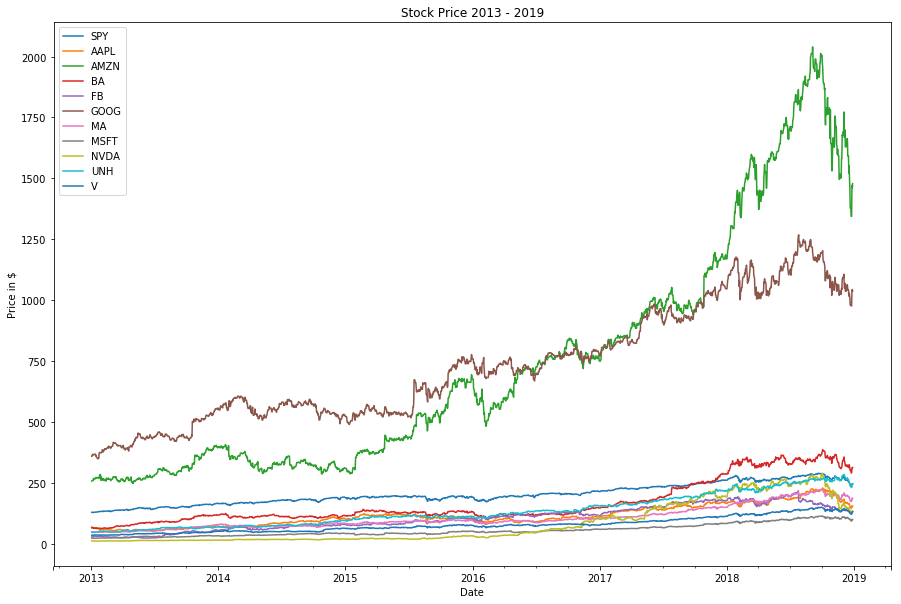

In [5]:
plt.figure(figsize=(15,10))
for stock in stocks:
    data[stock]['adj close'].plot()
plt.legend(stocks)
plt.ylabel("Price in $")
plt.title('Stock Price 2013 - 2019')

# Set constraints 

The zipline trading algorithm requires some information inputted into the parameters. The initial capital is the amount of money started at the begining of the simulation. We will begin with 10.000 for our project. In trading, it is better to invest will larger amounts of money to reduce the cost of trading fees. We will simulate trading for the year 2018 since is the latest time frame with complete observations for the whole year. The final parameter is setting the trading calendar. We want the algorithm to simulate trading in US market. This means that trades will only be made during weekdays and will exclude holidays. 

In [6]:
from datetime import datetime
from zipline.utils.calendars import get_calendar
# Constraints for our algorithm
initial_capital = 10000
# Time frame for our algorithm to run 
startDate = datetime(2018,1,1,0,0,0,0,pytz.utc)
endDate = datetime(2018,12,28,0,0,0,0,pytz.utc)
# Trading calendar used for algorithm
tradingCalendar = get_calendar('NYSE')
tradingCalendar

In [7]:
# Import necessary functions needed for zipline
from zipline.api import symbol, order_percent, order, get_open_orders, order_target_percent
from zipline.api import set_benchmark,record, history, sid
from zipline.api import set_commission, schedule_function
from zipline.finance.commission import PerTrade
from zipline.protocol import BarData
from zipline import run_algorithm
from zipline.api import date_rules, time_rules
from zipline.finance.blotter.blotter import Blotter
from zipline.finance.ledger import Ledger
from sklearn.covariance import LedoitWolf, OAS
import cvxpy as cvx
from cvxpy import *
# Stokcs to be used in portfolio

portfolioStocks = ["AAPL", "AMZN", "BA", "FB", "GOOG", "MA", "MSFT", "NVDA", "UNH", "V"]

# Simple Moving Average

In this model, we will be using a simple moving average as a baseline for the perfomance for the rest of our models. A simple moving average is essentially using historical data to determine the trend of the future marker. The two perdiods for this model will be 50 and 21 days. To begin with, we indicate to our function to calculate the SMA every 21 days which will determine if there is a need to a place an order. For the simplicity of this model, we will be using 0.1 as the proportion for each stock. 

,AAPL,AMZN,BA,FB,GOOG,LongAvg,MA,MSFT,NVDA,ShortAvg,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2018-01-02 21:00:00+00:00,172.26,1189.01,296.84,181.42,1065.00,354.91426,151.91,85.95,199.35,361.659952,...,0.00,0.00,0,NaN,10000.00000,0.00,0.00,1,[],0.0
2018-01-03 21:00:00+00:00,172.23,1204.20,297.80,184.67,1082.48,354.91426,153.82,86.35,212.47,361.659952,...,0.00,0.00,0,-11.224972,10000.00000,0.00,0.00,2,"[{'amount': 5, 'dt': 2018-01-03 21:00:00+00:00...",0.0
2018-01-04 21:00:00+00:00,173.03,1209.59,296.67,184.33,1086.40,354.91426,155.81,87.11,213.59,361.659952,...,0.00,0.00,0,-2.337260,2524.54393,7432.14,7432.14,3,[],0.0
2018-01-05 21:00:00+00:00,175.00,1229.14,308.84,186.85,1102.23,354.91426,159.04,88.19,215.40,361.659952,...,0.00,0.00,0,23.406937,2524.54393,7464.27,7464.27,4,[],0.0
2018-01-08 21:00:00+00:00,174.35,1246.87,310.15,188.28,1106.94,354.91426,159.27,88.28,222.00,361.659952,...,0.00,0.00,0,25.978509,2524.54393,7602.90,7602.90,5,[],0.0
2018-01-09 21:00:00+00:00,174.33,1252.70,318.43,187.87,1106.26,354.91426,159.50,88.22,221.94,361.659952,...,0.00,0.00,0,27.507467,2524.54393,7634.06,7634.06,6,[],0.0
2018-01-10 21:00:00+00:00,174.29,1254.33,320.26,187.84,1102.61,354.91426,159.86,87.82,223.68,361.659952,...,0.00,0.00,0,25.989241,2524.54393,7659.81,7659.81,7,[],0.0
2018-01-11 21:00:00+00:00,175.28,1276.68,328.12,187.77,1105.52,354.91426,160.92,88.08,224.08,361.659952,...,0.00,0.00,0,30.801830,2524.54393,7663.65,7663.65,8,[],0.0
2018-01-12 21:00:00+00:00,177.09,1305.20,336.21,179.37,1122.26,354.91426,162.33,89.60,222.98,361.659952,...,0.00,0.00,0,32.142201,2524.54393,7714.69,7714.69,9,[],0.0
2018-01-16 21:00:00+00:00,176.19,1304.86,335.16,178.39,1121.76,354.91426,162.29,88.35,220.11,361.659952,...,0.00,0.00,0,25.283027,2524.54393,7740.69,7740.69,10,[],0.0


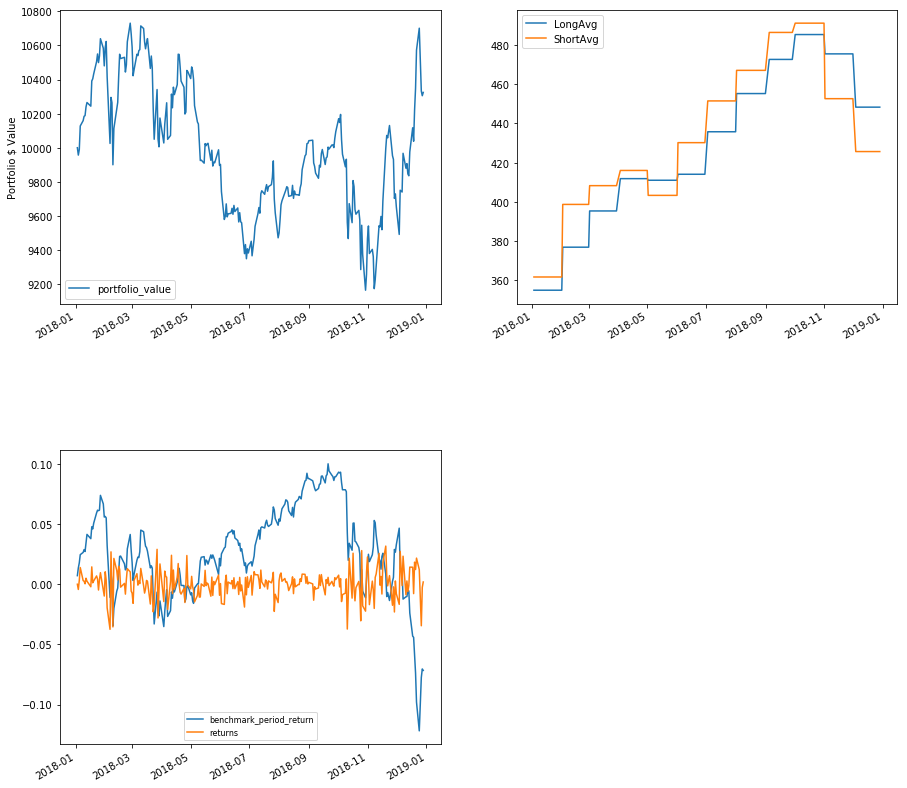

In [8]:
def periodFunc2(context,data):
    
        
    shortAvg = data.history(context.stocks, context.price, context.LBShort, context.LBTick).mean()
    longAvg = data.history(context.stocks, context.price, context.LBLong, context.LBTick).mean()
    
    shortAvg = shortAvg.mean()
    longAvg = longAvg.mean()
    
    record(ShortAvg = shortAvg)
    record(LongAvg = longAvg)
    
    if shortAvg > longAvg:
        for stock in context.ManStocks:
            order_target_percent(symbol(stock),0.1)
    else:
        for stock in context.ManStocks:             
            order_target_percent(symbol(stock),-0.1)
            


def startAlgo2(context):
    # Benchmark to compare the returns
    set_benchmark(symbol('SPY'))
    # Cost per trade
    set_commission(PerTrade(cost = 4.95))
    # load stocks into our algorithm
    context.stocks = [symbol("AAPL"),symbol("AMZN"),symbol("BA"),symbol("FB"),symbol("GOOG"),
                     symbol("MA"),symbol("MSFT"),symbol("NVDA"),symbol("UNH"),symbol("V"),]
    
    context.ManStocks = portfolioStocks
    
    
    context.price = 'price'
    
    context.LBShort = 21
    
    context.LBLong = 50
    
    context.LBTick = '1d'
    
    schedule_function(periodFunc2, date_rules.month_start(),
                     time_rules.market_close())

    
    
def handles(context, data):
    record(AAPL = data.current(symbol('AAPL'),'price'))
    
    record(AMZN = data.current(symbol('AMZN'),'price'))
    
    record(BA = data.current(symbol('BA'),'price'))
    
    record(FB = data.current(symbol('FB'),'price'))
    
    record(GOOG = data.current(symbol('GOOG'),'price'))
    
    record(MA = data.current(symbol('MA'),'price'))
    
    record(MSFT = data.current(symbol('MSFT'),'price'))
    
    record(NVDA = data.current(symbol('NVDA'),'price'))
    
    record(UNH = data.current(symbol('UNH'),'price'))
    
    record(V = data.current(symbol('V'),'price'))
    

def GraphInsight2(context, perf2):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(221)
    perf2.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio $ Value')
    plt.legend(loc=0)
    ax2 = fig.add_subplot(222)
    perf2[['LongAvg','ShortAvg']].plot(ax=ax2)
    ax3 = fig.add_subplot(223)
    perf2.benchmark_period_return.plot(ax=ax3)
    perf2.returns.plot(ax=ax3)
    plt.legend(loc=8,prop= {"size":8})
    plt.subplots_adjust(hspace = 0.5)


    
    

perf2 = zipline.run_algorithm(start= startDate,
                                 end= endDate,
                                 initialize=startAlgo2,
                                 data_frequency='daily',
                                 capital_base= initial_capital,
                                 trading_calendar=tradingCalendar,
                                 analyze=GraphInsight2,
                                 handle_data=handles,
                                 data=StockPrice)

perf2

# Another method with LW

,AAPL,AMZN,BA,FB,GOOG,LogReturns,MA,MSFT,NVDA,UNH,...,sigma_LW,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,weights,weightsSum
2018-01-02 21:00:00+00:00,172.26,1189.01,296.84,181.42,1065.00,Equity(3 [AAPL]) E...,151.91,85.95,199.35,221.16,...,0 1 2 3 ...,NaN,10000.000000,0.00,0.00,1,[],0.0,"[0.16366204411208995, 0.12703548505984674, 0.2...",1.0
2018-01-03 21:00:00+00:00,172.23,1204.20,297.80,184.67,1082.48,Equity(3 [AAPL]) E...,153.82,86.35,212.47,223.48,...,0 1 2 3 ...,-11.224972,10000.000000,0.00,0.00,2,"[{'amount': 9, 'dt': 2018-01-03 21:00:00+00:00...",0.0,"[0.16366204411208995, 0.12703548505984674, 0.2...",1.0
2018-01-04 21:00:00+00:00,173.03,1209.59,296.67,184.33,1086.40,Equity(3 [AAPL]) E...,155.81,87.11,213.59,224.45,...,0 1 2 3 ...,-5.191804,933.306565,9012.05,9012.05,3,[],0.0,"[0.16366204411208995, 0.12703548505984674, 0.2...",1.0
2018-01-05 21:00:00+00:00,175.00,1229.14,308.84,186.85,1102.23,Equity(3 [AAPL]) E...,159.04,88.19,215.40,228.73,...,0 1 2 3 ...,26.342930,933.306565,9035.61,9035.61,4,[],0.0,"[0.16366204411208995, 0.12703548505984674, 0.2...",1.0
2018-01-08 21:00:00+00:00,174.35,1246.87,310.15,188.28,1106.94,Equity(3 [AAPL]) E...,159.27,88.28,222.00,224.76,...,0 1 2 3 ...,21.924389,933.306565,9247.26,9247.26,5,[],0.0,"[0.16366204411208995, 0.12703548505984674, 0.2...",1.0
2018-01-09 21:00:00+00:00,174.33,1252.70,318.43,187.87,1106.26,Equity(3 [AAPL]) E...,159.50,88.22,221.94,225.88,...,0 1 2 3 ...,28.757284,933.306565,9237.21,9237.21,6,[],0.0,"[0.16366204411208995, 0.12703548505984674, 0.2...",1.0
2018-01-10 21:00:00+00:00,174.29,1254.33,320.26,187.84,1102.61,Equity(3 [AAPL]) E...,159.86,87.82,223.68,224.20,...,0 1 2 3 ...,25.933637,933.306565,9313.40,9313.40,7,[],0.0,"[0.16366204411208995, 0.12703548505984674, 0.2...",1.0
2018-01-11 21:00:00+00:00,175.28,1276.68,328.12,187.77,1105.52,Equity(3 [AAPL]) E...,160.92,88.08,224.08,225.39,...,0 1 2 3 ...,35.511940,933.306565,9307.97,9307.97,8,[],0.0,"[0.16366204411208995, 0.12703548505984674, 0.2...",1.0
2018-01-12 21:00:00+00:00,177.09,1305.20,336.21,179.37,1122.26,Equity(3 [AAPL]) E...,162.33,89.60,222.98,228.64,...,0 1 2 3 ...,47.773021,933.306565,9422.51,9422.51,9,[],0.0,"[0.16366204411208995, 0.12703548505984674, 0.2...",1.0
2018-01-16 21:00:00+00:00,176.19,1304.86,335.16,178.39,1121.76,Equity(3 [AAPL]) E...,162.29,88.35,220.11,232.90,...,0 1 2 3 ...,46.231537,933.306565,9578.53,9578.53,10,[],0.0,"[0.16366204411208995, 0.12703548505984674, 0.2...",1.0


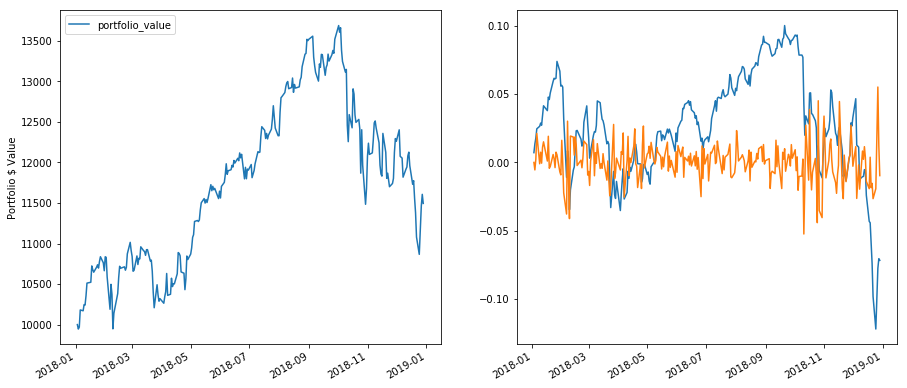

In [9]:


def rebalance3(context,data):
    
    LBDataframe = data.history(context.stocks, context.price, context.LBShort, context.LBTick)
            
    logret = np.log(LBDataframe).diff()
    
    record(LogReturns = logret)
    
    mu = logret[1:].mean()
    
    record(meanReturns = mu)
    
    # Estimate covariance matrix
    
    sigma = logret.cov()
    
    record(covarianceMatrix = sigma)
    
    # implement LW
    
    X = logret.dropna()
    LW_cov = LedoitWolf().fit(X)
    sigma_LW = LW_cov.covariance_
    sigma_LW = pd.DataFrame(sigma_LW)
    record(sigma_LW = sigma_LW)
    
    # Optimzation
    s, _ = sigma_LW.shape
    #gamma = cvx.Parameter(nonneg=True)
    w1 = cvx.Variable(s)
    risk = cvx.quad_form(w1, sigma_LW.values)
    prob1 = cvx.Problem(cvx.Minimize(risk), 
               [cvx.sum(w1) == 1])
    prob1.solve()
    weights = w1.value
    record(weights = weights)
    weightsSum = weights.sum()
    record(weightsSum = weightsSum) # this will output 1.0 which it does
    
    for stock, portion in zip(context.ManStocks, weights):
        order_target_percent(symbol(stock), portion)

def startAlgo3(context):
    # Benchmark to compare the returns
    set_benchmark(symbol('SPY'))
    # Cost per tradea
    set_commission(PerTrade(cost = 4.95))
    # load stocks into our algorithm
    context.stocks = [symbol("AAPL"),symbol("AMZN"),symbol("BA"),symbol("FB"),symbol("GOOG"),
                     symbol("MA"),symbol("MSFT"),symbol("NVDA"),symbol("UNH"),symbol("V")]
    
    context.ManStocks = portfolioStocks
    
    
    context.price = 'price'
    
    context.LBShort = 21
    
    context.LBLong = 100
    
    context.LBTick = '1d'
    
    schedule_function(rebalance3, date_rules.month_start(),
                     time_rules.market_close())

    
def GraphInsight3(context, perf3):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(221)
    perf3.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio $ Value')
    plt.legend(loc=0)
    ax2 = fig.add_subplot(222)
    perf3.benchmark_period_return.plot()
    perf3.returns.plot()
    

perf3 = zipline.run_algorithm(start= startDate,
                              end= endDate,
                              initialize=startAlgo3,
                              data_frequency='daily',
                              capital_base= initial_capital,
                              trading_calendar=tradingCalendar,
                              analyze=GraphInsight3,
                              handle_data=handles, # Its the same for now, records price daily
                              data=StockPrice)
perf3

# Model with Estimated parameters and moving average

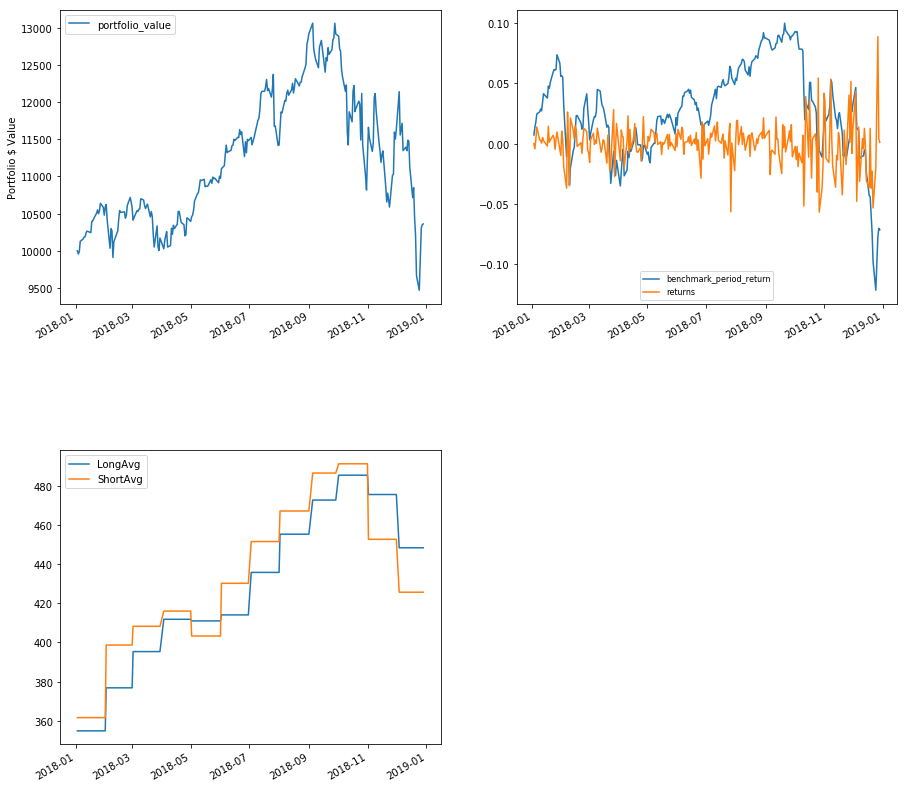

In [10]:
def rebalance4(context,data):
    LBDataframe = data.history(context.stocks, context.price, context.LBShort, context.LBTick)
    
    shortAvg = data.history(context.stocks, context.price, context.LBShort, context.LBTick).mean()
    longAvg = data.history(context.stocks, context.price, context.LBLong, context.LBTick).mean()
    
    record(ShortAvg = shortAvg)
    record(LongAvg = longAvg)
    
    shortAvg = shortAvg.mean()
    longAvg = longAvg.mean()
            
    logret = np.log(LBDataframe).diff()
    
    meanLogret = logret.mean().mean()
    
    record(MeanLog= meanLogret)
    
    record(LogReturns = logret)
    
    mu = logret[1:].mean()
    
    record(meanReturns = mu)
    
    # Estimate covariance matrix
    
    sigma = logret.cov()
    
    record(covarianceMatrix = sigma)
    
    # implement LW
    s,_ = sigma.shape

    w = cvx.Variable(s)
    risk = cvx.quad_form(w, sigma.values)
    prob = cvx.Problem(cvx.Minimize(risk), 
               [
                   cvx.sum(w) == 1,
                   mu.values*w >= 0.001
               ])
    prob.solve()
    weights = w.value
    
    record(Weights = weights)
    
    record(Contraint1 = weights.sum())
    
    # estimated portfolio returns
    earned = np.dot(logret.fillna(method='bfill').values, weights).mean()
    
    record(PerdiodEearned = earned)
    
    # This constraint is not really met
    record(Constraint2 = np.dot(mu.values, weights))
    # buy percentage
    if context.Traded is False:
        for stock in context.ManStocks:
            order_target_percent(symbol(stock),0.1)
        context.Traded = True
    else:
        if earned < meanLogret:
            for stock, prop in zip(context.ManStocks, weights):
                order_target_percent(symbol(stock),prop)

    
def startAlgo4(context):
        #Benchmark to compare returns
        set_benchmark(symbol("SPY"))
        # cost per Trade
        set_commission(PerTrade(4.95))
        # load stocks into our algorithm
        context.stocks = [symbol("AAPL"),symbol("AMZN"),symbol("BA"),symbol("FB"),symbol("GOOG"),
                          symbol("MA"),symbol("MSFT"),symbol("NVDA"),symbol("UNH"),symbol("V")]
        # loads stocks name into our algorithm
        context.ManStocks = portfolioStocks
        
        context.price = 'price'
    
        context.LBShort = 21
    
        context.LBLong = 100
    
        context.LBTick = '1d'
        
        schedule_function(rebalance4, date_rules.month_start(),
                     time_rules.market_close())
        
        context.Traded = False
        
def GraphInsight4(context, perf4):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(221)
    perf4.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio $ Value')
    plt.legend(loc=0)
    ax2 = fig.add_subplot(222)
    perf4.benchmark_period_return.plot(ax=ax2)
    perf4.returns.plot(ax=ax2)
    plt.legend(loc=8,prop= {"size":8})
    plt.subplots_adjust(hspace = 0.5)
    ax3 = fig.add_subplot(223)
    perf2[['LongAvg','ShortAvg']].plot(ax=ax3)
    
    
perf4 = zipline.run_algorithm(start= startDate,
                              end= endDate,
                              initialize=startAlgo4,
                              data_frequency='daily',
                              capital_base= initial_capital,
                              trading_calendar=tradingCalendar,
                              analyze=GraphInsight4,
                              handle_data=handles, # Its the same for now, records price daily
                              data=StockPrice)